# Bayesian Hierarchical Model based on asteroseismology paper

The oscillatory signature of the second ionization zone of helium in the second differences can be described by the following function:

$\Delta_2\omega_{n,l}=A_{n,l}exp(-2b^{2}\omega_{n,l}^2)cos[2(\tau_{HeII}\omega_{n,l}+d)]+K$

where $\omega_{n,l}$ and $\Delta_2\omega_{n,l}$ are the angular versions of $\nu_{n,l}$ (the frequency of the nth overtone of the p mode with spherical harmonic degree l) and $\Delta_2\nu_{n,l}$ (the second difference in
the p-mode frequencies) respectively, $A$ is the amplitude of the oscillatory component, $\tau_{HeII}$ is the acoustic depth of the second ionization zone of helium, $b$ is the characteristic width of the region, $d$ is a constant that accounts for the phase of the signal, and $K$ is a constant offset.

This forms a decaying sine wave with some phase $\phi$:

$y(t) = Asin(\omega t + \phi)e^{-2bt}$

With initial values $A=5$, $b = 0.2$, $\phi = \frac{\pi}{4}$ and an angular frequency of $\omega = 2\pi$.

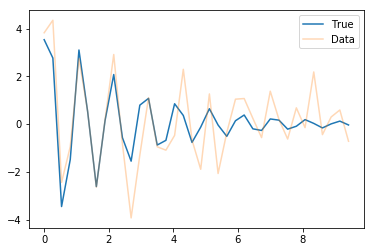

In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

N = 36 # 360 (reduced by factor 10 to appear more like astero data)
nint = 3
Atru = 5
btru = 0.2
omegatru = 2*np.pi
phitru = np.pi/4

t = np.linspace(0, np.pi*nint, N)
ftru = Atru*np.sin(t*omegatru + phitru)*np.exp(-2*btru*t)

sigma = np.ones(N)
fobs = ftru + sigma*np.random.randn(N)

fig, ax = plt.subplots()
ax.plot(t, ftru, label='True')
ax.plot(t, fobs, alpha=0.3, label='Data')
ax.legend()

In [7]:
code = '''
functions {
    real sin(real omega, real A, real phi, real t){
        return A*sin(omega*t + phi);
    }
    real exp(real b, real t){
        return exp(-2*b*t);
    }
    
}
data {
    int N;
    real t[N];
    real f[N]; 
    real func[N];
}
parameters {
    real<lower=0> omega;
    real<lower=0> A;
    real<lower=0> b;
    real<lower=0, upper=3.14159> phi;
}
model {
    vector[N] mod;
    omega ~ normal(6.2, 0.8);
    A ~ normal(5.0, 1.0);
    b ~ normal(0.2, 0.05);
    phi ~ normal(0.8, 0.4);
    for (i in 1:N) mod[i] = sin(omega, A, phi, t[i])*exp(b, t[i]);
    mod ~ normal(f, func);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_27c3df4554f4e6b192de8150e87f0746 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpj8ii8yin/stanfit4anon_model_27c3df4554f4e6b192de8150e87f0746_8357777650033263034.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [8]:
stan_data = {'N': len(t),
             't': t, 
             'f': fobs,
             'func': sigma}
start = {'omega' : 6.5}
nchains = 4
fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [9]:
print(fit)

Inference for Stan model: anon_model_27c3df4554f4e6b192de8150e87f0746.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
omega   6.22  9.4e-4   0.08   6.06   6.17   6.23   6.28   6.37   6682    1.0
A       5.18  7.4e-3   0.61   4.01   4.77   5.18   5.59   6.37   6749    1.0
b       0.18  4.0e-4   0.03   0.12   0.16   0.18    0.2   0.25   6764    1.0
phi      0.7  1.7e-3   0.14   0.43   0.61    0.7   0.79   0.98   7033    1.0
lp__  -17.83    0.02   1.45 -21.42 -18.58  -17.5 -16.76 -16.01   4441    1.0

Samples were drawn using NUTS at Mon Nov 26 15:19:05 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


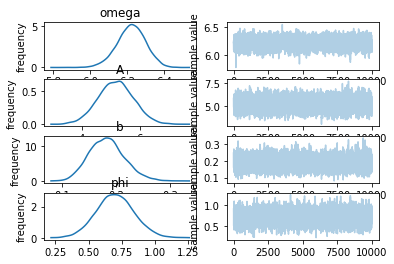

In [10]:
fit.plot()
plt.show()

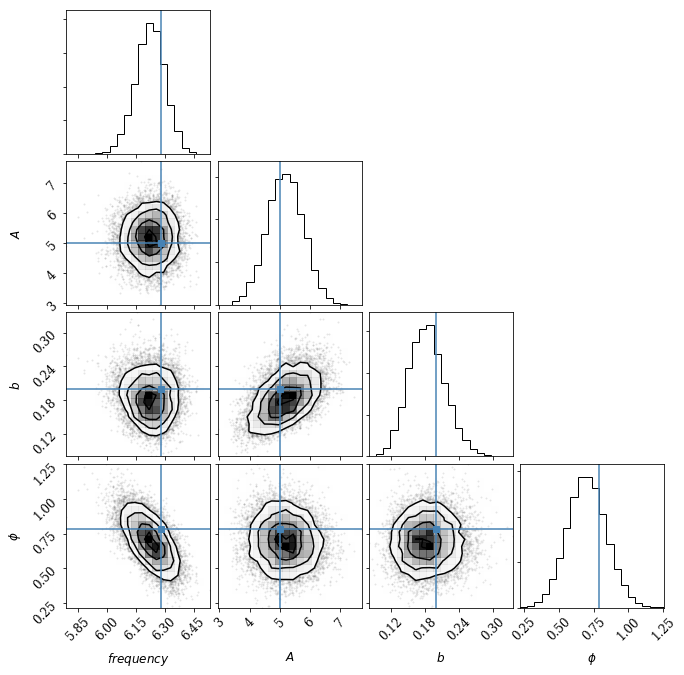

In [11]:
import corner
plt.rc("font", family="serif", size=12)
data = np.vstack([fit['omega'], fit['A'], fit['b'], fit['phi']]).T
corner.corner(data, labels=[r'$frequency$', r'$A$', r'$b$', r'$\phi$'], truths=[omegatru, Atru, btru, phitru])
plt.show()

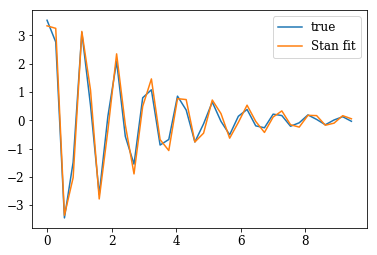

In [12]:
st = fit['A'].mean()*np.sin(t*fit['omega'].mean()+fit['phi'].mean())*np.exp(-2*fit['b'].mean()*t)
plt.plot(t, ftru, label = 'true')
plt.plot(t, st, label = 'Stan fit')
plt.legend()

All parameters are recovered quite well, however after some compilations (with no code changes) Stan finds the phi prob distribution as bimodal, which affects the mean taken to plot a comparison to true data.